In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# The functional api can handle

- models with non-linear topology
- shared layers
- multiple inputs or outputs


# Main idea
- A deep learning is usually a directed acyclic graph of layers.

# Functional API is a

way to build graphs of layers

# A simple example

## The shape of the data is set as a 784 dim vector

- The batch size is always omitted since only the shape of each sample is specified.
- inputs contains information about shape and dtype.

In [ ]:
inputs = keras.Input(shape = (784,))
print(inputs.shape)
print(inputs.dtype)

(None, 784)
<dtype: 'float32'>


## Create a new node in the graph of layers by calling a layer on inputs object.
- layer call is like drawing an arrow from inputs to this layer.
- Passing the inputs to the dense layer, and get x as the output


In [ ]:
dense = layers.Dense(64,activation="relu")
x = dense(inputs)
# passing inputs to the layer. x is output

# Add a layer to the graph

In [ ]:
x = layers.Dense(64,activation = "relu")(x)
outputs = layers.Dense(10)(x)

# Specifying its inputs and outputs in the graph

In [ ]:
model = keras.Model(inputs = inputs,outputs = outputs,name = "mnist_model")
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


# Plot the model as a graph

- The connection arrows are replaced by the call operation.


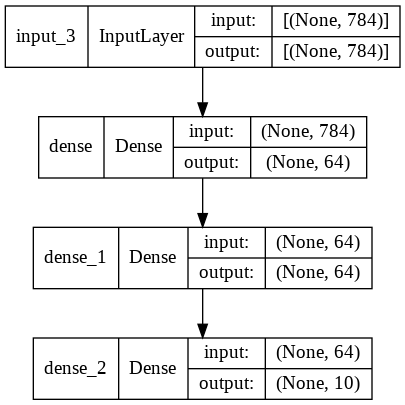

In [ ]:
keras.utils.plot_model(model,"my_first_model.png",show_shapes=True)

# Training, evaluation and inference

- Work in the same way for models built using functional api as for sequential.
- Model class offers a builtin training loop and evaluation loop.
- I can customize these loops.
- compile -> fit -> evaluate

In [ ]:
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000,784).astype("float32") / 255
x_test = x_test.reshape(10000,784).astype("float32") / 255

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.RMSprop(),
    metrics = ["accuracy"]
)

history = model.fit(x_train,y_train,batch_size=64 , epochs = 2, validation_split = 0.2)

test_scores = model.evaluate(x_test,y_test,verbose=2)


Epoch 1/2
750/750 [==============================] - 4s 4ms/step - loss: 0.3405 - accuracy: 0.9019 - val_loss: 0.1944 - val_accuracy: 0.9431
Epoch 2/2
750/750 [==============================] - 3s 4ms/step - loss: 0.1583 - accuracy: 0.9529 - val_loss: 0.1395 - val_accuracy: 0.9599
313/313 - 0s - loss: 0.1305 - accuracy: 0.9613 - 410ms/epoch - 1ms/step


# Save and serialize

- Same way as Sequential models.
- The standard way to save a functional model = call model.save()

- Saved file includes
  - architecture
  - weight values
  - training config, if any
  - optimizer and its state

  

In [ ]:
model.save("path_to_my_model")

del model

model = keras.models.load_model("path_to_model")

INFO:tensorflow:Assets written to: path_to_my_model/assets


# Use the same graph of layers to define multiple models

- A single graph of layers can be used to generate multiple models.
- Use the same stack of layers to instantiate several models.

# Q. In this code, autoencoder can be built regardless of the part below. Why is it in the code ?

  encoder = keras.Model(encoder_input,encoder_output,name = "encoder")
  
  encoder.summary()

  In my opiniop, it is needed to extract hidden variables which contain original data.

In [ ]:
encoder_input = keras.Input(shape = (28,28,1),name = "img")
x = layers.Conv2D(16,3,activation = "relu")(encoder_input)
x = layers.Conv2D(32,3,activation = "relu")(x)
x = layers.MaxPool2D(3)(x)
x = layers.Conv2D(32,3,activation = "relu")(x)
x = layers.Conv2D(16,3,activation = "relu")(x)

encoder_output = layers.GlobalMaxPool2D()(x)

encoder = keras.Model(encoder_input,encoder_output,name = "encoder")
encoder.summary()

x = layers.Reshape((4,4,1))(encoder_output)
x = layers.Conv2DTranspose(16,3,activation="relu")(x)
x = layers.Conv2DTranspose(32,3,activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16,3,activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1,3,activation = "relu")(x)


autoencoder = keras.Model(encoder_input,decoder_output,name = "autoencoder")

autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 6, 6, 32)          9248      
                                                                 
 conv2d_19 (Conv2D)          (None, 4, 4, 16)          4624      
                                                           

# All models are callable, just like layers

- Use any model as if it were a layer by calling it on an Input or on the output of another layer.



# Q. By calling a model you aren't just reusing the architecture of the mode, you're also reusing its weights -> what does it mean?

# encoder encoder -> chains them in two calls to obtain the autoencoder

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 org_img (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 conv2d_29 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_30 (Conv2D)          (None, 6, 6, 32)          9248      
                                                                 
 conv2d_31 (Conv2D)          (None, 4, 4, 16)          4624      
                                                           

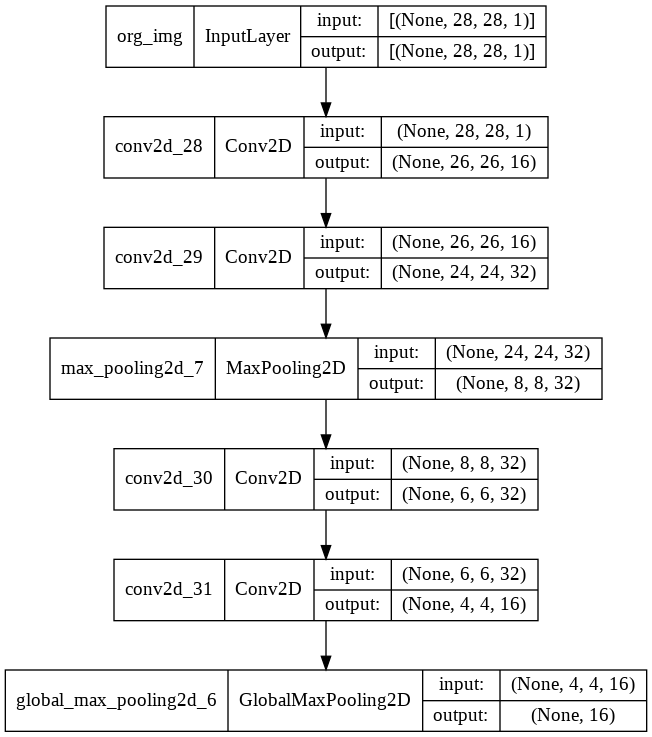

In [ ]:
encoder_input = keras.Input(shape = (28,28,1),name = "org_img")
x = layers.Conv2D(16,3,activation = "relu")(encoder_input)
x = layers.Conv2D(32,3,activation = "relu")(x)
x = layers.MaxPool2D(3)(x)
x = layers.Conv2D(32,3,activation = "relu")(x)
x = layers.Conv2D(16,3,activation = "relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input,encoder_output,name = "encoder")
encoder.summary()
keras.utils.plot_model(encoder,"my_first_model.png",show_shapes=True)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoded_img (InputLayer)    [(None, 16)]              0         
                                                                 
 reshape_5 (Reshape)         (None, 4, 4, 1)           0         
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 6, 6, 16)         160       
 Transpose)                                                      
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 8, 8, 32)         4640      
 Transpose)                                                      
                                                                 
 up_sampling2d_5 (UpSampling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                           

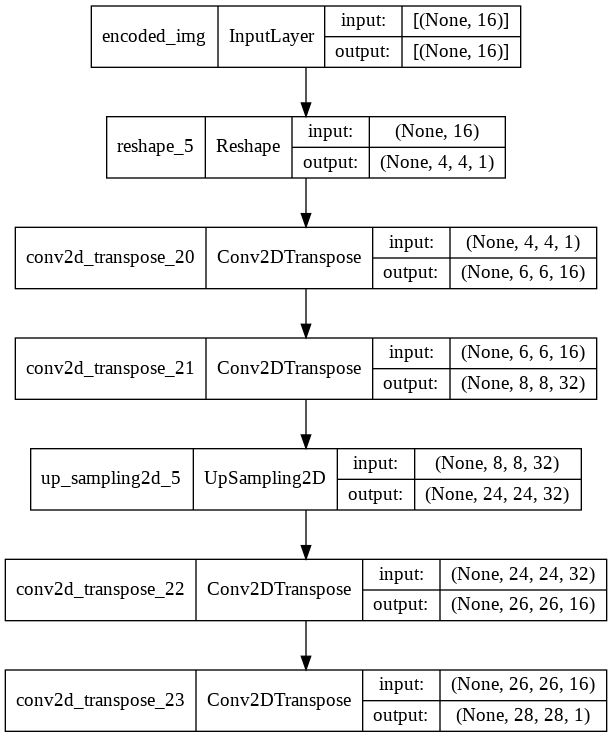

In [ ]:
decoder_input = keras.Input(shape=(16,),name = "encoded_img")
x = layers.Reshape((4,4,1))(decoder_input)
x = layers.Conv2DTranspose(16,3,activation = "relu")(x)
x = layers.Conv2DTranspose(32,3,activation = "relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16,3,activation="relu")(x)
decoder_output=layers.Conv2DTranspose(1,3,activation = "relu")(x)

decoder = keras.Model(decoder_input,decoder_output,name = "decoder")
decoder.summary()
keras.utils.plot_model(decoder,"my_first_model.png",show_shapes=True)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 16)                18672     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         9569      
                                                                 
Total params: 28,241
Trainable params: 28,241
Non-trainable params: 0
_________________________________________________________________


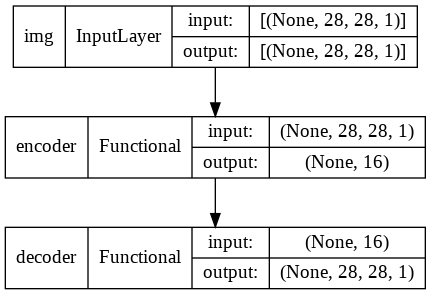

In [ ]:
mautoencoder_input = keras.Input(shape = (28,28,1),name = "img")

encoder_img = encoder(autoencoder_input)
decoder_img = decoder(encoder_img)

autoencoder = keras.Model(autoencoder_input,decoder_img,name = "autoencoder")
autoencoder.summary()
keras.utils.plot_model(autoencoder,"my_first_model.png",show_shapes=True)

# A model can contain sub-models

- Because a model is like a layer.
- A common use case is ensembling.


In [ ]:
def get_model():
  inputs = keras.Input(shape =(128,))
  outputs = layers.Dense(1)(inputs)
  return keras.Model(inputs,outputs)

model1 = get_model()
model2 = get_model()
model3 = get_model()


model1.summary()
model2.summary()
model3.summary()


inputs = keras.Input(shape = (128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)

outputs = layers.average([y1,y2,y3])

ensemble_model = keras.Model(inputs = inputs,outputs = outputs)

ensemble_model.summary()

# Input-layer also have input and output. In many cases, Input layer is set several times.

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 128)]             0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


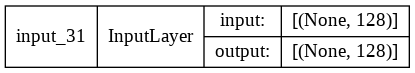

In [ ]:
inputs1 = keras.Input(shape = (128,))
input1_model=keras.Model(inputs1,inputs1)
input1_model.summary()
keras.utils.plot_model(input1_model,"my_first_model.png",show_shapes=True)

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 128)]             0         
                                                                 
 model_23 (Functional)       (None, 128)               0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


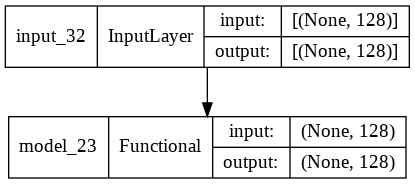

In [ ]:
inputs2 = keras.Input(shape = (128,))
isitright=input1_model(inputs2)
mm=keras.Model(inputs2,isitright)
mm.summary()
keras.utils.plot_model(mm,"my_first_model.png",show_shapes=True)